Victor CHAU & Tahar AMAIRI
# IFT 870 - Forage de données
## TP3 : onctions prédictives

### Sommaire

[TODO]

## Importation des données

In [1]:
# import libs
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

# read CSV
data = pd.read_csv('TP3_data.csv', index_col=0)

# cast classe column to in
data['Classe'] = data['Classe'].astype(int)

# print the df
data.head()

,Attribut1,Attribut2,Attribut3,Attribut4,Classe
0,-8.850074,4.041708,-4.545313,-4.578589,18
1,1.009469,-9.347073,-6.515912,9.669842,5
2,5.939861,0.718491,-0.564980,3.312923,8
3,5.629454,1.395495,-0.424261,4.603658,8
4,-6.229520,3.496113,2.202815,10.431126,10


In [2]:
# split into X and y arrays
X = data.iloc[:,0:4].to_numpy()
y = data['Classe'].to_numpy()

## 1. Implémentation de fonctions
### a) ```model_score(class_model, X, y, params)```

In [3]:
def model_score(class_model, X, y, params):
    # split idx into 5 folds
    idxSplit = np.array_split(np.arange(0,X.shape[0]), 5)
    # to store the accuracy for each validation
    accList = list()
    # train mask
    idxTrain = np.ones(X.shape[0],dtype=bool)
    # set parameters
    class_model.set_params(**params)

    # loop over each test idx
    for idxTest in idxSplit:
        # set up mask
        idxTrain[idxTest] = 0
        # get train sets
        Xtrain, YTrain = X[idxTrain], y[idxTrain]
        # get test sets
        Xtest, YTest = X[idxTest], y[idxTest]
        # train model
        class_model.fit(Xtrain, YTrain)
        # get prediction score
        accList.append(class_model.score(Xtest, YTest))
        # reset mask
        idxTrain[:] = True

    # return mean accuracy
    return np.mean(accList)

In [4]:
# test
class_model = KNeighborsClassifier()
params = {'n_neighbors': 10, 'p': 5}
model_score(class_model, X, y, params)

0.9987999999999999

### b) ```bruteforce_optimisation(class_model, X, y, grille_param)```

In [5]:
def bruteforce_optimisation(class_model, X, y, grille_param):
    # to store the best accuracy from the cv
    bestAcc = 0.0
    # same here but for the parameters of the model
    bestPara = None
    
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = [dict(zip(keys, comb)) for comb in combinations] # zipped in list of dict 

    # grid search
    for params in grid:
        # get acc from cv
        acc = model_score(class_model, X, y, params)
        # update
        if acc > bestAcc:
            bestAcc = acc
            bestPara = params

    # return best parameters
    return bestPara

In [6]:
# test
grille_param = {'n_neighbors': range(1,20), 'p': range(1,10)}
bruteforce_optimisation(class_model, X, y, grille_param)

{'n_neighbors': 7, 'p': 3}

### c) ```randomize_optimisation(class_model, X, y, grille_param, sample_percent)```

In [7]:
def randomize_optimisation(class_model, X, y, grille_param, sample_percent):
    # check sample_percent value
    if sample_percent > 100 or sample_percent < 0:
        raise ValueError("sample_percent needs to in [0,100]")
    
    # to store the best accuracy from the cv
    bestAcc = 0.0
    # same here but for the parameters of the model
    bestPara = None

    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = [dict(zip(keys, comb)) for comb in combinations] # zipped in list of dict
    
    # shuffle
    np.random.shuffle(grid)
    # get a sample percent
    grid = grid[0:int(len(grid) * sample_percent / 100)]

    # grid search
    for params in grid:
        # get acc from cv
        acc = model_score(class_model, X, y, params)
        # update
        if acc > bestAcc:
            bestAcc = acc
            bestPara = params

    # return best parameters
    return bestPara

In [8]:
# test
sample_percent = 30
randomize_optimisation(class_model, X, y, grille_param, sample_percent)

{'n_neighbors': 9, 'p': 5}

### d) ```halving_optimisation(class_model, X, y, grille_param, n_splitting)```

In [9]:
def halving_optimisation(class_model, X, y, grille_param, n_splitting):
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # to store acc for each parameters
    accList = list()
    # size of the grid
    P = len(grid)
    # data size
    N = X.shape[0]
    # grid idx
    idx = range(0,P)

    # halving iter
    for i, j in zip(range(0, n_splitting), range(1, n_splitting + 1)):
        # get search & data space
        p = int(P * (n_splitting - i) / n_splitting)
        n = int(N * j / n_splitting)

        # get the corresponding data
        xn = X[0:n,:]
        yn = y[0:n]

        # get the best parameters
        grid = grid[idx[0:p]]
        
        # clear accuracy
        accList.clear()

        # grid search
        for params in grid:
        # append negative acc from cv (because of argsort)
           accList.append(- model_score(class_model, xn, yn, params))

        # get idx of sorted parameters based on the accuracy
        idx = np.argsort(accList)

    # return best parameters
    return grid[0]

In [10]:
# test
n_splitting = 5
halving_optimisation(class_model, X, y, grille_param, n_splitting)

{'n_neighbors': 3, 'p': 6}

### e) ```bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter)```

In [11]:
def bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter):
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # transform the grid search space into a matrix
    M = np.array([list(params.values()) for params in grid])

    # set s_size accordingly to the number of parameters
    s_size = len(grid) if len(grid) < s_size else s_size

    # generate a sample of size s_size
    sampleIdx = np.random.choice(M.shape[0], s_size, replace=False)
    E = M[sampleIdx, :]

    # to cache the accuracy of sampled parameters
    accList = list()

    # get accuracy of the sampled parameters
    for params in E:
        # get acc from cv
        accList.append(model_score(class_model, X, y, dict(zip(keys, params))))

    # fit the approximation function
    GPR = GaussianProcessRegressor()
    GPR.fit(E, accList)

    # Bayesian search
    for _ in range(n_iter):
        # predict the scores of all parameters
        score = GPR.predict(M, return_std=True)

        # get the maximum mean from the predictions
        max_pred_moy = np.max(score[0])

        # generate a sample of size s_size
        sampleIdx = np.random.choice(M.shape[0], s_size, replace=False)
        sample = M[sampleIdx, :]

        # predict the scores of the sample
        scoreSample = GPR.predict(sample, return_std=True)

        # compute prob
        prob = (scoreSample[0] - max_pred_moy) / (scoreSample[1] + 10e-6)
        
        # get the parameter corresponding to the maximum proba
        max_param = sample[np.argmax(prob)]
        
        # add it to E
        E = np.vstack([E, max_param])

        # get the accuracy of the sampled parameter
        accList.append(model_score(class_model, X, y, dict(zip(keys, max_param))))

        # fit the approximation function
        GPR.fit(E, accList)

    # return best parameters
    return dict(zip(keys, E[np.argmax(accList)]))

In [12]:
# test
s_size = 5
n_iter = 100
bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter)

{'n_neighbors': 18, 'p': 9}

## 2. Comparaison de fonctions
### a) Partitionnement en données d’entraînement et de test

In [13]:
from sklearn.model_selection import train_test_split

# use sklearn function to split into 70% train / 30% test set
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3)

### b) Heatmaps

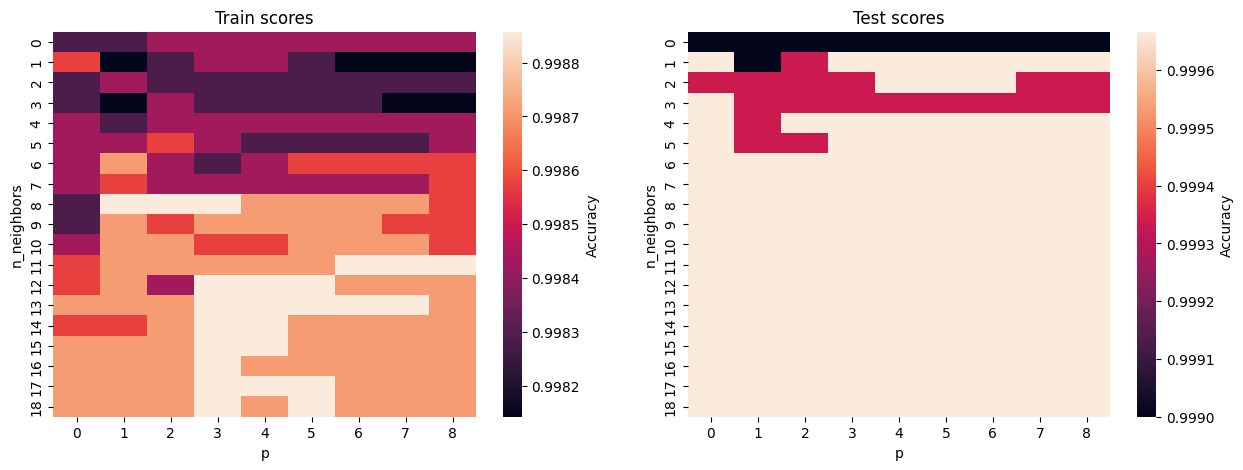

In [32]:
# parameters
class_model = KNeighborsClassifier()
n_neighbors = range(1,20)
P = range(1,10)

# to store scores
trainScore, testScore = np.zeros((len(n_neighbors), len(P))), np.zeros((len(n_neighbors), len(P)))

# get all the scores
for i, n in enumerate(n_neighbors):
    for j, p in enumerate(P):
        # get train scores using cv
        trainScore[i,j] = model_score(class_model, XTrain, yTrain, {'n_neighbors': n, 'p': p})
        # get test scores
        testScore[i,j] = class_model.score(XTest, yTest)

# set subplot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

# add titles
ax1.set_title('Train scores');
ax2.set_title('Test scores');

# plot heatmaps
heatMapTrain = sns.heatmap(trainScore, ax = ax1, cbar_kws={'label': 'Accuracy'}, annot=True);
heatMapTest = sns.heatmap(testScore, ax = ax2, cbar_kws={'label': 'Accuracy'}, annot=True);

# add labels
heatMapTrain.set(xlabel='p', ylabel='n_neighbors');
heatMapTest.set(xlabel='p', ylabel='n_neighbors');

### c) Réglages des hyperparamètres avec les fonctions